Ch1

In [2]:
import pandas as pd
data_raw = pd.read_csv('data_ml.csv')
idx_date = data_raw.index[(
    data_raw['date'] > '1999-12-31') & (
    data_raw['date'] < '2019-01-01')].tolist()
#날짜를 받기 위한 인덱스 생성
data_ml = data_raw.iloc[idx_date]
#날짜 인덱스에 따라 데이터셋 필터링
data_ml.iloc[0:6, 0:6]

,stock_id,date,Advt_12M_Usd,Advt_3M_Usd,Advt_6M_Usd,Asset_Turnover
0,13,2006-12-31,0.25,0.33,0.27,0.22
1,13,2007-01-31,0.25,0.32,0.28,0.22
2,13,2007-02-28,0.26,0.30,0.30,0.22
3,17,2015-03-31,0.73,0.64,0.70,0.40
4,17,2015-04-30,0.72,0.62,0.66,0.40
5,17,2015-05-31,0.71,0.63,0.64,0.40


Text(0, 0.5, 'nb_assets')

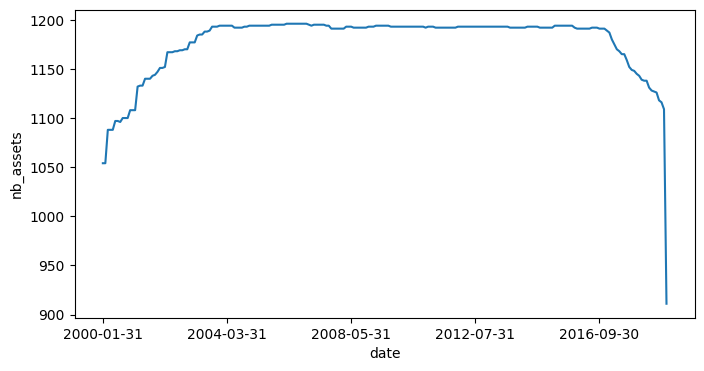

In [3]:
import matplotlib.pyplot as plt
pd.Series(data_ml.groupby('date').size()).plot(figsize=(8,4))
# 각 날짜별 자산 개수 세기
plt.ylabel('nb_assets')
# y축 제목을 추가한 후 그래프 그리기

In [4]:
features = list(data_ml.iloc[:, 3:95].columns)
# 특성의 열 이름 저장 
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd",
                  "Mom_11M_Usd", "Ocf", "Pb", "Vol1Y_Usd"]

Text(0, 0.5, 'count')

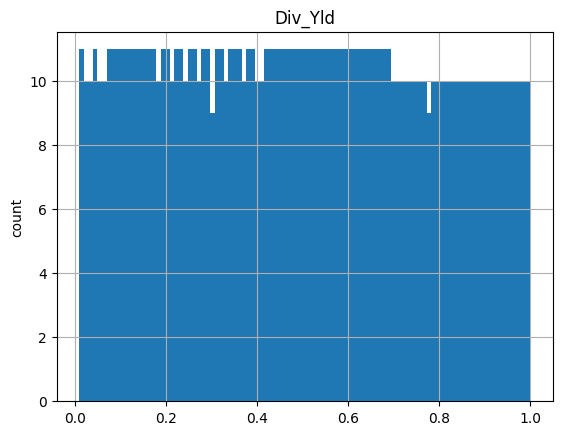

In [5]:
# 특성 Div_Yld 열
col_feat_Div_Yld = data_ml.columns.get_loc('Div_Yld')
# 필터링할 부울 인덱스 생성
is_custom_date = data_ml['date'] =='2000-02-29'
# 히스토그램 사용
data_ml[is_custom_date].iloc[:, [col_feat_Div_Yld]].hist(bins=100)
plt.ylabel('count')

'매수' '유지' '매도' 같은 범주를 예측 시 (분류 분석) 수치형 레이블이 아닌 범주형 레이블을 추가적으로 생성

In [6]:
df_median = []
df = []

import numpy as np
df_median = data_ml[['date', 'R1M_Usd', 'R12M_Usd']].groupby(
    ['date']).median()
df_median.rename(
    columns={"R1M_Usd": "R1M_Usd_median",
             "R12M_Usd": "R12M_Usd_median"}, inplace=True)

df = pd.merge(data_ml, df_median, how='left', on=['date'])

data_ml['R1M_Usd_C'] = np.where(
    df['R1M_Usd'] > df['R1M_Usd_median'], 1.0, 0.0)
data_ml['R12M_Usd_C'] = np.where(
    df['R12M_Usd'] > df['R12M_Usd_median'], 1.0, 0.0)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_28056\2378900137.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ml['R1M_Usd_C'] = np.where(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_28056\2378900137.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ml['R12M_Usd_C'] = np.where(


데이터셋 분리

In [7]:
sepration_date = "2014-01-15"
idx_train = data_ml.index[(data_ml['date']<sepration_date)].tolist()
idx_test = data_ml.index[(data_ml['date']>=sepration_date)].tolist()

자산 식별 코드 및 수익률 데이터프레임 같은 주요 변수를 따로 메모리에 보관  
후자의 계산을 간단하게 하기 위해 투자 유니버스를 축소해 데이터 포인트가 최대로 있는 종목들만 유지

In [8]:
stock_ids_short = []
stock_days = []

# 각 주식별 데이터 포인트 개수 세기
stock_ids = data_ml['stock_id'].unique()
stock_days = data_ml[['date', 'stock_id']].groupby(
    ['stock_id']).count().reset_index()

# 데이터가 모두 있는 주식을 리스트로 변환
stock_ids_short = stock_days.loc[
    stock_days['date'] == (stock_days['date'].max())]
stock_ids_short = stock_ids_short['stock_id'].unique()
is_stock_ids_short = data_ml['stock_id'].isin(stock_ids_short)
returns = data_ml[is_stock_ids_short].pivot(
    index='date', columns='stock_id', values='R1M_Usd'
)

Ch3

사이즈 팩터 포트폴리오 계산

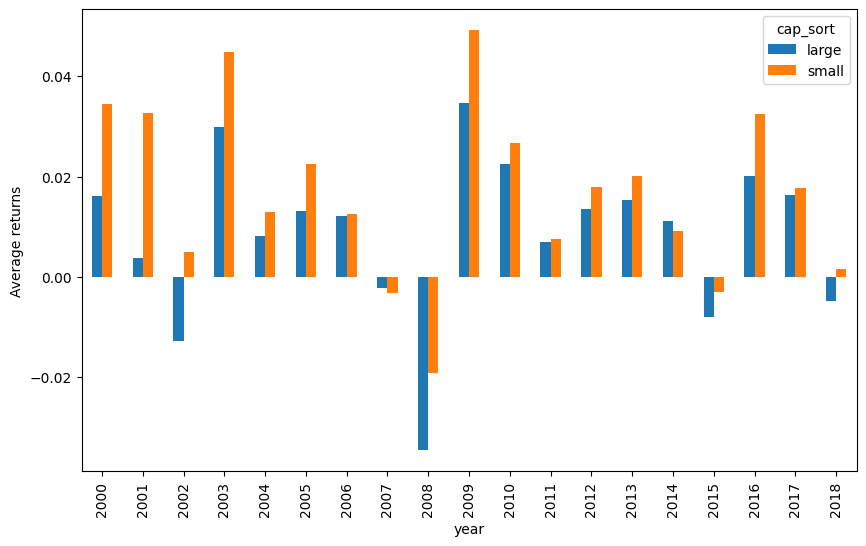

In [11]:
df_median = []
df = []

df_median = data_ml[['date', 'Mkt_Cap_12M_Usd']].groupby(
    ['date']).median().reset_index()
df_median.rename(
    columns = {'Mkt_Cap_12M_Usd' : 'cap_median'}, inplace=True)

# 연도 및 시가총액 로직 설정 후 그룹화
df = pd.merge(
    data_ml[["date", 'Mkt_Cap_12M_Usd', 'R1M_Usd']],
    df_median, how='left', on=['date'])
df = df.groupby(
    [pd.to_datetime(df['date']).dt.year, np.where(
        df['Mkt_Cap_12M_Usd'] > df['cap_median'],
        'large', 'small')])['R1M_Usd'].mean().reset_index()
df.rename(columns = {'level_1' : 'cap_sort'}, inplace=True)
df.pivot(index='date', columns='cap_sort', values='R1M_Usd').plot.bar(figsize = (10,6))
plt.ylabel('Average returns')
plt.xlabel('year')

# 임시 데이터프레임을 제거해 가볍게 만들자!
df_median = []
df = []


In [ ]:
# 사이즈 팩터 : 소형주 대 대형주 평균 수익률

주요 이상 현상 - 케네스 프렌치의 데이터 라이브러리 / AQR 저장소.  
이 책에서는 케네스 프렌치의 데이터

In [45]:
import urllib.request
min_date = 196307
max_date = 202003
# 다운로드 URL
#ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp"
#ff_url += "/F-F_Research_Data_5_Factors_2x3_CSV.zip"
# 다운로드
#urllib.request.urlretrieve(ff_url, 'factors.zip')

df_ff = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv',
                    header=2, sep=',', quotechar='"')
df_ff.rename(columns = {'Unnamed: 0':'date'}, inplace=True)
df_ff.rename(columns = {'Mkt-RF':'MKT_RF'}, inplace=True)

# 숫자형으로 변환할 열 지정
cols_to_convert = ['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
df_ff['date'] = pd.to_numeric(df_ff['date'], errors='coerce')

# 각 열을 숫자형으로 변환 (숫자가 아닌 값은 NaN으로 처리)
df_ff[cols_to_convert] = df_ff[cols_to_convert].apply(pd.to_numeric, errors='coerce')

# 열 값 스케일링 (백분율 -> 소수점 변환)
df_ff[cols_to_convert] = df_ff[cols_to_convert] / 100.0

#df_ff[['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']] = df_ff[['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']].values/100.0 #수익률 스케일링
idx_ff = df_ff.index[(df_ff['date']>=min_date) & (
    df_ff['date'] <= max_date)].tolist()
FF_factors = df_ff.iloc[idx_ff]
FF_factors['year'] = FF_factors.date.astype(str).str[:4]
FF_factors.iloc[1:6,0:7].head()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_28056\3024586893.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FF_factors['year'] = FF_factors.date.astype(str).str[:4]


,date,MKT_RF,SMB,HML,RMW,CMA,RF
1,196308.0,0.0507,-0.0080,0.0180,0.0036,-0.0035,0.0025
2,196309.0,-0.0157,-0.0052,0.0013,-0.0071,0.0029,0.0027
3,196310.0,0.0253,-0.0139,-0.0010,0.0280,-0.0201,0.0029
4,196311.0,-0.0085,-0.0088,0.0175,-0.0051,0.0224,0.0027
5,196312.0,0.0183,-0.0210,-0.0002,0.0003,-0.0007,0.0029
